<a href="https://colab.research.google.com/github/belovelace/AI-study/blob/main/WISDM_SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.layers import Multiply

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report


# Import necessary layers for the CNN-Transformer model
from tensorflow.keras.layers import Conv2D, MultiHeadAttention, LayerNormalization, Add, Reshape, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [2]:

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/drive/MyDrive/AI_study/WISDM_ar_v1.1_raw.txt",
                 header=None,
                 sep=',',
                 names=['user', 'activity', 'timestamp', 'x', 'y', 'z'],
                 on_bad_lines='skip')

Mounted at /content/drive


In [3]:
df['z'] = df['z'].astype(str).str.replace(';', '').str.strip()

# 결측값 제거
df = df.dropna()

print(f"데이터 로딩 완료: {df.shape}")
df.head()


데이터 로딩 완료: (1086466, 6)


,user,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [4]:

print(f"df 존재: {'df' in globals()}")
if 'df' in globals():
    print(f"df 크기: {df.shape}")
    print(f"df 비어있음: {df.empty}")


df 존재: True
df 크기: (1086466, 6)
df 비어있음: False


In [5]:

label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df


,user,activity,timestamp,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.50395286
1,33,1,49106062271000,5.012288,11.264028,0.95342433
2,33,1,49106112167000,4.903325,10.882658,-0.08172209
3,33,1,49106222305000,-0.612916,18.496431,3.0237172
4,33,1,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086461,19,2,131623331483000,9.000000,-1.570000,1.69
1086462,19,2,131623371431000,9.040000,-1.460000,1.73
1086463,19,2,131623411592000,9.080000,-1.380000,1.69
1086464,19,2,131623491487000,9.000000,-1.460000,1.73


In [6]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [7]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [8]:

#train, test 분리
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 2832]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df = df[df['user'].isin(train_users)].copy()
test_df  = df[df['user'].isin(test_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()

# NaN 값 제거
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()


print("======데이터 분할(사용자 기반)=====")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

======데이터 분할(사용자 기반)=====
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 36명, 데이터 수: 1086465
테스트용 사용자 수: 4명, 데이터 수: 120055


In [9]:

# Define the features to be scaled
features = ['x', 'y', 'z']

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform all dataframes
scaler.fit(train_df[features])        # 훈련 데이터로만 학습
train_df[features] = scaler.transform(train_df[features])  # 동일 기준 적용
val_df[features] = scaler.transform(val_df[features])      # 동일 기준 적용
test_df[features] = scaler.transform(test_df[features])    # 동일 기준 적용

print("데이터 스케일링 완료")

데이터 스케일링 완료


In [10]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [11]:
TIME_PERIOD = 80
STEP_DISTANCE = 40
LABEL = 'activity'

In [12]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [14]:
#훈련 데이터셋
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#검증 데이터셋
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#테스트 데이터셋
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

# x_train = x_train / np.max(np.abs(x_train)) # 이 부분 제거
# x_val = x_val / np.max(np.abs(x_val)) # 이 부분 제거

print("훈련 데이터:", x_train.shape, y_train_hot.shape)
print("검증 데이터", x_val.shape, y_val_hot.shape)

print("====================================")

x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1) # 제거
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1) # 제거
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1) # 제거

x_train.shape, x_val.shape

훈련 데이터: (20575, 80, 3) (20575, 6)
검증 데이터 (27160, 80, 3) (27160, 6)


((20575, 80, 3, 1), (27160, 80, 3, 1))

In [15]:


# 스케일링된 훈련 데이터 (x_train)의 통계 정보 확인
print("x_train descriptive statistics:")
print("Mean:", np.mean(x_train))
print("Standard Deviation:", np.std(x_train))
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

# x_train에 nan 또는 무한대 값이 있는지 확인
print("\nChecking x_train for NaN and Inf values:")
print("Contains NaN:", np.isnan(x_train).any())
print("Contains Inf:", np.isinf(x_train).any())

x_train descriptive statistics:
Mean: -5.122355e-06
Standard Deviation: 1.0000106
Min: -4.1887546
Max: 3.958978

Checking x_train for NaN and Inf values:
Contains NaN: False
Contains Inf: False


In [16]:

# 원-핫 인코딩된 훈련 레이블 (y_train_hot) 확인
print("y_train_hot shape:", y_train_hot.shape)

# y_train_hot에 nan 또는 무한대 값이 있는지 확인
print("\nChecking y_train_hot for NaN and Inf values:")
print("Contains NaN:", np.isnan(y_train_hot).any())
print("Contains Inf:", np.isinf(y_train_hot).any())

# 각 샘플의 레이블 합계 확인 (원-핫 인코딩 확인)
print("\nChecking sum of each row in y_train_hot:")
row_sums = np.sum(y_train_hot, axis=1)
print("All row sums are 1:", np.all(row_sums == 1))
print("Unique row sums:", np.unique(row_sums))

# y_train_hot의 값 범위 확인
print("\ny_train_hot value range:")
print("Min value:", np.min(y_train_hot))
print("Max value:", np.max(y_train_hot))

y_train_hot shape: (20575, 6)

Checking y_train_hot for NaN and Inf values:
Contains NaN: False
Contains Inf: False

Checking sum of each row in y_train_hot:
All row sums are 1: True
Unique row sums: [1.]

y_train_hot value range:
Min value: 0.0
Max value: 1.0


In [17]:
def se_block(input_tensor, reduction_ratio=8):
  #입력 텐서로부터 채널 수 가져오기
  channels=input_tensor.shape[-1]

  #Squeeze: 글로벌 평균 풀링으로 각 채널의 공간 정보 압축
  se=GlobalAveragePooling2D()(input_tensor)
  se=Reshape((1,1,channels))(se)

  #Excitation
  se=Dense(channels//reduction_ratio, activation='relu')(se)
  se=Dense(channels, activation='sigmoid')(se)

  #학습된 중요도를 원래의 feature map에 곱하기
  return Multiply()([input_tensor, se])

### SENet

In [25]:
def build_senet_model(input_shape, num_classes):
  inputs=Input(shape=input_shape)

  l2_reg=regularizers.l2(0.001)

  x=Conv2D(16, (2,2), activation='relu', padding='same', kernel_regularizer=l2_reg)(inputs)
  x=BatchNormalization()(x)
  x=se_block(x)
  x=Dropout(0.2)(x)

  x=Conv2D(32, (2,2), activation='relu', padding='same', kernel_regularizer=l2_reg)(x)
  x=BatchNormalization()(x)
  x=se_block(x)
  x=Dropout(0.5)(x)

  x=Flatten()(x)
  x=Dense(64, activation='relu', kernel_regularizer=l2_reg)(x)
  x=Dropout(0.6)(x)
  outputs=Dense(num_classes, activation='softmax')(x)
  model=Model(inputs=inputs, outputs=outputs)
  return model

input_shape=(TIME_PERIOD, 3, 1)
num_classes=y_train_hot.shape[1]
model=build_senet_model(input_shape, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 80, 3, 16) │         80 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 16) │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 16)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 2)   │         34 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 16)  │         48 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 80, 3, 16) │          0 │ batch_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 3, 16) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 80, 3, 32) │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 4)   │        132 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 1, 32)  │        160 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 80, 3, 32) │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 3, 32) │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 7680)      │          0 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │    491,584 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 6)         │        390 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 494,700 (1.89 MB)

 Trainable params: 494,604 (1.89 MB)

 Non-trainable params: 96 (384.00 B)

In [26]:
optimizer=Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict=dict(enumerate(class_weights))

early_stop=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history=model.fit(
    x_train, y_train_hot,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val_hot),
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4463 - loss: 1.4698 - val_accuracy: 0.6684 - val_loss: 0.9492
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6310 - loss: 0.9776 - val_accuracy: 0.7334 - val_loss: 0.8601
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6713 - loss: 0.8591 - val_accuracy: 0.7615 - val_loss: 0.8053
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7052 - loss: 0.8000 - val_accuracy: 0.7914 - val_loss: 0.7784
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7216 - loss: 0.7543 - val_accuracy: 0.7876 - val_loss: 0.7562
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7443 - loss: 0.7012 - val_accuracy: 0.8133 - val_loss: 0.7240
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7600 - loss: 0.6726 - val_accuracy: 0.8216 - val_loss: 0.6829
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.7641 - loss: 0.6609 - val_accuracy:

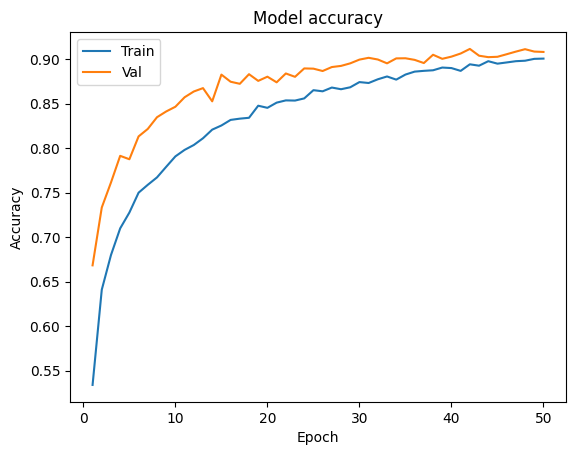

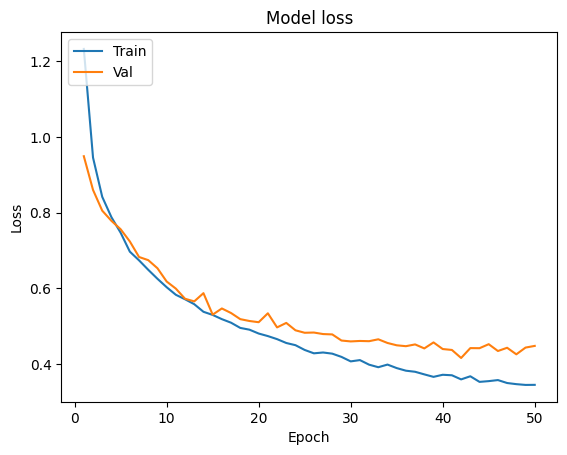

In [36]:
plot_learningCurve(history, epochs=50)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


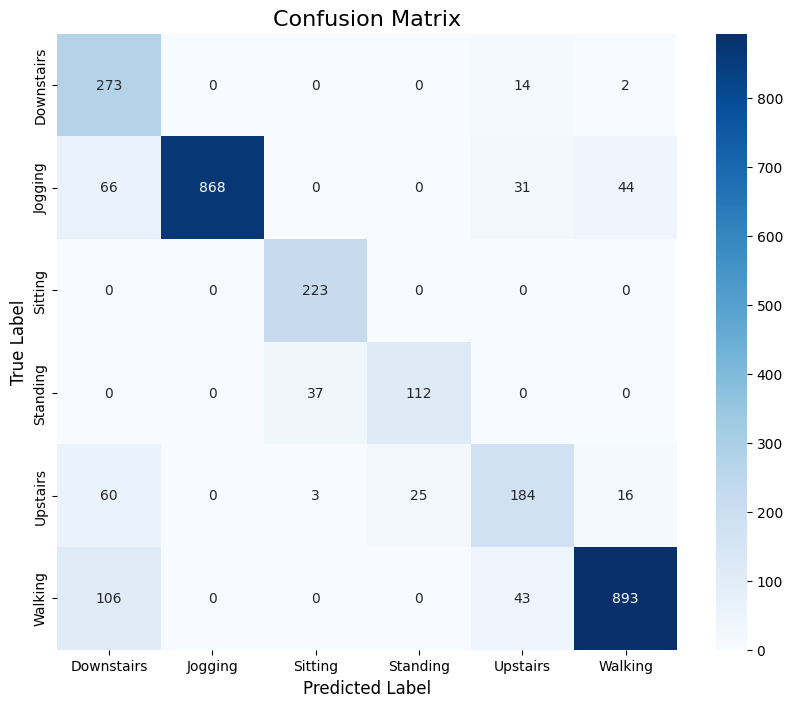

In [34]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [37]:
loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)


테스트 데이터 정확도 (Accuracy): 0.8510
테스트 데이터 손실 (Loss): 0.6850


In [38]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n===== 분류 리포트 =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== 분류 리포트 =====
              precision    recall  f1-score   support

  Downstairs       0.54      0.94      0.69       289
     Jogging       1.00      0.86      0.92      1009
     Sitting       0.85      1.00      0.92       223
    Standing       0.82      0.75      0.78       149
    Upstairs       0.68      0.64      0.66       288
     Walking       0.94      0.86      0.89      1042

    accuracy                           0.85      3000
   macro avg       0.80      0.84      0.81      3000
weighted avg       0.88      0.85      0.86      3000

